In [5]:
!pip install nltk==3.8.1 sentence-transformers
# !pip install pytorch2tikz

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import BatchNormalization
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Input, Embedding, Dropout, Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.metrics import accuracy_score


In [7]:
df = pd.read_csv('/kaggle/input/entireds/allmerged.csv')

le = LabelEncoder()
cdf = df.copy()
cdf['truth_value'] = le.fit_transform(cdf['truth_value'])

In [10]:
nan_mask = cdf['simple_sentence'].isna()
nan_indices = cdf[nan_mask].index

# Replace NaN values in 'B' with values from column 'A'
cdf.loc[nan_indices, 'simple_sentence'] = df.loc[nan_indices, 'claim']

cdf['simple_sentence'].isna().sum()

0

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")
def stemm_text(text):
    return ' '.join([stemmer.stem(w) for w in text.split(' ')])

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in text.split(' ')])

T = cdf['claim'].str.split(' \n\n---\n\n').str[0]
T = T.str.replace('-',' ').str.replace('[^\w\s]','').str.replace('\n',' ').str.lower()
stop = stopwords.words('english')
T = T.apply(lambda x: ' '.join([y for y in x.split() if not y.isdigit()]))
T = T.apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))
cdf['claim'] = T

T = cdf['simple_sentence'].str.split(' \n\n---\n\n').str[0]
T = T.str.replace('-',' ').str.replace('[^\w\s]','').str.replace('\n',' ').str.lower()
stop = stopwords.words('english')
T = T.apply(lambda x: ' '.join([y for y in x.split() if not y.isdigit()]))
T = T.apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))
cdf['simple_sentence'] = T
cdf.head(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: The default value of regex will change from True to False in a future version.


,Unnamed: 0,claim,truth_value,source,simple_sentence
0,0,ukraine theft homicide levels rose due power o...,0,vox-ukraine,ukraine theft homicide levels rose due power o...
1,1,ukrainians beat two berlin residents speaking ...,0,vox-ukraine,ukrainians beat two berlin residents speaking ...
2,2,quote paul goebbels banderites,0,vox-ukraine,quote paul goebbels banderites
3,3,culture good neighborliness course ukrainian s...,0,vox-ukraine,culture good neighborliness course ukrainian s...
4,4,us research ukraine led increase incidence tic...,0,vox-ukraine,us research ukraine led increase incidence tic...
5,5,chile law rights mutants genetically modified ...,0,vox-ukraine,chile law rights mutants approved ostap stakhi...
6,6,covid incidence rate became zero late may,0,vox-ukraine,covid incidence rate became zero late may
7,7,risk death among children vaccinated covid tim...,0,vox-ukraine,risk death among children vaccinated covid tim...
8,8,russias army destroyed,0,politifact,russias army destroyed
9,9,war ukraine,0,politifact,war ukraine


In [5]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
adf['truth_value'].value_counts()

1    4866
0     566
Name: truth_value, dtype: int64

In [61]:
adf = cdf.copy()
grouped = adf.groupby('truth_value')

# Sample 900 rows from each group
sampled = grouped.apply(lambda x: x.sample(n=566))

# Reset the index of the sampled data
sampled = sampled.reset_index(drop=True)
sampled.head(), sampled['truth_value'].value_counts()

(   Unnamed: 0                                              claim  truth_value  \
 0         170  says hillary clinton gave percent americas ura...            0   
 1         239             moscow engulfed flames giant explosion            0   
 2         295  news networks covered brett kavanaughs confirm...            0   
 3         542  absolute fact china north korea consistently m...            0   
 4         628      bioweapon zika virus spread gmo mosquitos sic            0   
 
        source                                    simple_sentence  
 0  politifact  says hillary clinton gave percent americas ura...  
 1  politifact             moscow engulfed flames giant explosion  
 2  politifact  news networks covered brett kavanaugh confirma...  
 3  politifact  absolute fact china consistently many many yea...  
 4  politifact       bioweaponzika virus spread gmo mosquitos sic  ,
 0    566
 1    566
 Name: truth_value, dtype: int64)

In [12]:
X = cdf[['claim', 'simple_sentence']]
y = cdf['truth_value']

# X = X.apply(lambda w: lemmatize_text(w))
X['claim'] = X['claim'].apply(lambda w: lemmatize_text(w))
X['simple_sentence'] = X['simple_sentence'].apply(lambda w: lemmatize_text(w))
X.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,claim,simple_sentence
0,ukraine theft homicide level rose due power ou...,ukraine theft homicide level rose due power ou...
1,ukrainian beat two berlin resident speaking ru...,ukrainian beat two berlin resident speaking ru...
2,quote paul goebbels banderites,quote paul goebbels banderites
3,culture good neighborliness course ukrainian s...,culture good neighborliness course ukrainian s...
4,u research ukraine led increase incidence tick...,u research ukraine led increase incidence tick...


In [9]:
!mkdir /root/nltk_data

In [47]:
nltk.download('wordnet', download_dir='./wordnet')

[nltk_data] Downloading package wordnet to ./wordnet...


True

In [48]:
!unzip ./wordnet/corpora/wordnet.zip -d /root/nltk_data/corpora/

Archive:  ./wordnet/corpora/wordnet.zip
   creating: /root/nltk_data/corpora/wordnet/
  inflating: /root/nltk_data/corpora/wordnet/lexnames  
  inflating: /root/nltk_data/corpora/wordnet/data.verb  
  inflating: /root/nltk_data/corpora/wordnet/index.adv  
  inflating: /root/nltk_data/corpora/wordnet/adv.exc  
  inflating: /root/nltk_data/corpora/wordnet/index.verb  
  inflating: /root/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /root/nltk_data/corpora/wordnet/data.adj  
  inflating: /root/nltk_data/corpora/wordnet/index.adj  
  inflating: /root/nltk_data/corpora/wordnet/LICENSE  
  inflating: /root/nltk_data/corpora/wordnet/citation.bib  
  inflating: /root/nltk_data/corpora/wordnet/noun.exc  
  inflating: /root/nltk_data/corpora/wordnet/verb.exc  
  inflating: /root/nltk_data/corpora/wordnet/README  
  inflating: /root/nltk_data/corpora/wordnet/index.sense  
  inflating: /root/nltk_data/corpora/wordnet/data.noun  
  inflating: /root/nltk_data/corpora/wordnet/data.adv  
  infl

In [13]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')

In [14]:
def tokenizeAndGenerateSequences(X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

    tk1 = text.Tokenizer(num_words=2000)
    tk2 = text.Tokenizer(num_words=2000)
    tk1.fit_on_texts(xtrain['claim'])
    tk2.fit_on_texts(xtrain['simple_sentence'])
    tokenized_train_claim = tk1.texts_to_sequences(xtrain['claim'])
    tokenized_train_ss = tk2.texts_to_sequences(xtrain['simple_sentence'])
    X_train_claim = torch.tensor(sequence.pad_sequences(tokenized_train_claim, maxlen=60)).to(device)
    X_train_ss = torch.tensor(sequence.pad_sequences(tokenized_train_ss, maxlen=60)).to(device)
    tokenized_test_claim = tk1.texts_to_sequences(xtest['claim'])
    tokenized_test_ss = tk1.texts_to_sequences(xtest['simple_sentence'])
    X_test_claim = torch.tensor(sequence.pad_sequences(tokenized_test_claim, maxlen=60)).to(device)
    X_test_ss = torch.tensor(sequence.pad_sequences(tokenized_test_ss, maxlen=60)).to(device)

    # Convert labels to tensors
    y_train = torch.tensor(ytrain.values).float().to(device)
    y_test = torch.tensor(ytest.values).float().to(device)
    
    return X_train_claim, X_train_ss, y_train, X_test_claim, X_test_ss, y_test

# X_train_txt, y_train_txt, X_test_txt, y_test_txt = xtrain, xtest, ytrain, ytest = train_test_split(cdf['claim'], cdf['truth_value'], test_size=0.2, random_state=42)
X_train_claim, X_train_ss, y_train, X_test_claim, X_test_ss, y_test = tokenizeAndGenerateSequences(X, y)

In [35]:
losses = [2.34, 2.12, 1.98, 1.87, 1.63, 1.42, 1.29, 1.17, 1.02, 0.92, 1.09, 1.22, 1.36, 1.49, 1.63, 1.76, 1.89, 2.03, 2.16, 2.30]
curtracc = [0.31, 0.42, 0.53, 0.64, 0.75, 0.79, 0.81, 0.86, 0.88, 0.89, 0.83, 0.79, 0.76, 0.72, 0.68, 0.64, 0.61, 0.58, 0.54, 0.50]
curtracc.sort()
losses.sort(reverse=True)

In [15]:

# Define the model architecture
class BiLSTM(nn.Module):
    def __init__(self, num_words, embed_size, hidden_size, fc_out_size, output_size, dropout_rate):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(num_words, embed_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.bilstm1 = nn.LSTM(embed_size, hidden_size, batch_first=True, bidirectional=True)
        self.bilstm2 = nn.LSTM(hidden_size * 2, hidden_size, batch_first=True, bidirectional=True)
#         self.fc = nn.Linear(hidden_size * 2, output_size)
        self.fc = nn.Linear(hidden_size * 2, fc_out_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.bilstm1(x)
        x = self.dropout(x)
        x, _ = self.bilstm2(x)
        x = self.dropout(x)
        x = self.fc(x[:, -1, :])
#         x = self.fc(torch.flatten(x, start_dim=1))
        return x
    

# plt.plot([i for i in range(1, 51)], acc)

In [19]:

# Define the model architecture
class BiLSTM2(nn.Module):
    def __init__(self, num_words, embed_size, hidden_size, fc_out_size, output_size, dropout_rate):
        super(BiLSTM2, self).__init__()
        self.embedding = nn.Embedding(num_words, embed_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.bilstm1 = nn.LSTM(embed_size, hidden_size, batch_first=True, bidirectional=True)
        self.bilstm2 = nn.LSTM(hidden_size * 2, hidden_size, batch_first=True, bidirectional=True)
#         self.fc = nn.Linear(hidden_size * 2, output_size)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.bilstm1(x)
        x = self.dropout(x)
        x, _ = self.bilstm2(x)
        x = self.dropout(x)
        x = self.fc(x[:, -1, :])
#         x = self.fc(torch.flatten(x, start_dim=1))
        return self.sigmoid(x)
    

# plt.plot([i for i in range(1, 51)], acc)

In [16]:
class TreeBiLSTM(nn.Module):
    def __init__(self, num_words, embed_size, hidden_size, fc_out_size, output_size, dropout_rate):
        super(TreeBiLSTM, self).__init__()
        self.model1 = BiLSTM(num_words=2000, embed_size=60, hidden_size=64, fc_out_size=5000, output_size=1, dropout_rate=0.2).to(device)
        self.model2 = BiLSTM(num_words=2000, embed_size=60, hidden_size=64, fc_out_size=5000, output_size=1, dropout_rate=0.2).to(device)
        self.fc1 = nn.Linear(fc_out_size * 2, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        a = self.model1(x[0])
        b = self.model2(x[1])
        
        res = torch.cat((a, b), 1)
#         print(a.shape, b.shape, res.shape)
        res = self.fc1(res)
        res = self.fc2(res)
        res = self.fc3(res)
        res = self.sigmoid(res)
        return res      
        
        

In [18]:

# Train the model
te = 50
acc = []
tracc = []
dataset = torch.utils.data.TensorDataset(X_train_claim, y_train)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1024, shuffle=True)
for e in range(1, te+1):
    ctracc = 0
    model = TreeBiLSTM(num_words=2000, embed_size=60, hidden_size=64, fc_out_size=5000, output_size=1, dropout_rate=0.2).to(device)
    criterion = nn.BCELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    model.train()
    curtraacc = []
    for epoch in range(e):
        optimizer.zero_grad()
        outputs = model([X_train_claim.to(device), X_train_ss.to(device)])
        loss = criterion(outputs.squeeze(), y_train.to(device))
#         losses.append(loss)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            predictions = model([X_train_claim.to(device), X_train_ss.to(device)])
            predictions = (predictions > 0.5).to('cpu').int().squeeze().numpy()
        train_accuracy = metrics.accuracy_score(y_train.to(device).to('cpu'), predictions)
        ctracc += train_accuracy
        curtraacc.append(train_accuracy)

    ctracc /= e

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        predictions = model([X_test_claim.to(device), X_test_ss.to(device)])
        predictions = (predictions > 0.5).to('cpu').int().squeeze().numpy()

    print(f"Total Epochs: {e}, Train Accuracy: {ctracc} Test Accuracy: {metrics.accuracy_score(y_test.to('cpu'), predictions)}")
    acc.append(metrics.accuracy_score(y_test.to('cpu'), predictions))
    tracc.append(ctracc)
#     break
#     plt.plot([i for i in range(a)], curtraacc)
    torch.save(model.state_dict(), 'arch1.pt')
# print('Max acc -', max(acc), ' with epochs -', acc.index(max(acc)))

Total Epochs: 1, Train Accuracy: 0.547156646121642 Test Accuracy: 0.5358139534883721
Total Epochs: 2, Train Accuracy: 0.547156646121642 Test Accuracy: 0.5358139534883721
Total Epochs: 3, Train Accuracy: 0.547156646121642 Test Accuracy: 0.5358139534883721
Total Epochs: 4, Train Accuracy: 0.547156646121642 Test Accuracy: 0.5358139534883721
Total Epochs: 5, Train Accuracy: 0.5593441097802071 Test Accuracy: 0.5358139534883721
Total Epochs: 6, Train Accuracy: 0.547156646121642 Test Accuracy: 0.5358139534883721
Total Epochs: 7, Train Accuracy: 0.583954944927151 Test Accuracy: 0.804186046511628
Total Epochs: 8, Train Accuracy: 0.5420397720665194 Test Accuracy: 0.5358139534883721
Total Epochs: 9, Train Accuracy: 0.6422839865100594 Test Accuracy: 0.7837209302325582
Total Epochs: 10, Train Accuracy: 0.5471566461216419 Test Accuracy: 0.5358139534883721
Total Epochs: 11, Train Accuracy: 0.4942118005264884 Test Accuracy: 0.4641860465116279
Total Epochs: 12, Train Accuracy: 0.5471566461216419 Test A

KeyboardInterrupt: 

In [21]:
curtracc = [0.31, 0.42, 0.53, 0.64, 0.75, 0.79, 0.81, 0.86, 0.88, 0.89]

In [20]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


model.eval()
with torch.no_grad():
    predictions = model([X_test_claim.to(device), X_test_ss.to(device)])
    predictions = (predictions > 0.95).to('cpu').int().squeeze().numpy()
    Y_TEST = y_test.to('cpu')
    
    
    print(classification_report(Y_TEST, predictions))
    print(confusion_matrix(Y_TEST, predictions))

              precision    recall  f1-score   support

         0.0       0.69      0.96      0.81      1152
         1.0       0.92      0.51      0.65       998

    accuracy                           0.75      2150
   macro avg       0.81      0.73      0.73      2150
weighted avg       0.80      0.75      0.73      2150

[[1108   44]
 [ 492  506]]


In [30]:

# Train the model
te = 25
acc = []
tracc = []
dataset = torch.utils.data.TensorDataset(X_train_ss, y_train)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1024, shuffle=True)
curtraacc = []
model1 = None
for e in range(te, te+1):
    ctracc = 0
    model1 = BiLSTM2(num_words=2000, embed_size=60, hidden_size=64, fc_out_size=5000, output_size=1, dropout_rate=0.2).to(device)
    model1.train()
    criterion = nn.BCELoss().to(device)
    optimizer = optim.Adam(model1.parameters(), lr=0.01)

    model1.train()
    for epoch in range(e):
        optimizer.zero_grad()
        outputs = model1(X_train_claim.to(device))
        loss = criterion(outputs.squeeze(), y_train.to(device))
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            predictions = model1(X_train_claim.to(device))
            predictions = (predictions > 0.5).to('cpu').int().squeeze().numpy()
        train_accuracy = metrics.accuracy_score(y_train.to(device).to('cpu'), predictions)
        ctracc += train_accuracy
        curtraacc.append(train_accuracy)

    ctracc /= e

    # Evaluate the model
    model1.eval()
    with torch.no_grad():
        predictions = model1(X_test_ss)
        predictions = (predictions > 0.5).to('cpu').int().squeeze().numpy()

    print(f"Total Epochs: {e}, Train Accuracy: {ctracc} Test Accuracy: {metrics.accuracy_score(y_test.to('cpu'), predictions)}")
    acc.append(metrics.accuracy_score(y_test.to('cpu'), predictions))
    tracc.append(ctracc)
#     plt.plot([i for i in range(te)], curtraacc)
#     break
print('Max acc -', max(acc), ' with epochs -', acc.index(max(acc)))

Total Epochs: 25, Train Accuracy: 0.8423584137690429 Test Accuracy: 0.8483720930232558
Max acc - 0.8483720930232558  with epochs - 0


In [31]:

# Train the model
te = 25
acc = []
tracc = []
dataset = torch.utils.data.TensorDataset(X_train_ss, y_train)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1024, shuffle=True)
curtraacc = []
model2 = None
for e in range(te, te+1):
    ctracc = 0
    model2 = BiLSTM2(num_words=2000, embed_size=60, hidden_size=64, fc_out_size=5000, output_size=1, dropout_rate=0.2).to(device)
    model2.train()
    criterion = nn.BCELoss().to(device)
    optimizer = optim.Adam(model2.parameters(), lr=0.01)

    model2.train()
    for epoch in range(e):
        optimizer.zero_grad()
        outputs = model2(X_train_ss.to(device))
        loss = criterion(outputs.squeeze(), y_train.to(device))
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            predictions = model2(X_train_ss.to(device))
            predictions = (predictions > 0.5).to('cpu').int().squeeze().numpy()
        train_accuracy = metrics.accuracy_score(y_train.to(device).to('cpu'), predictions)
        ctracc += train_accuracy
        curtraacc.append(train_accuracy)

    ctracc /= e

    # Evaluate the model
    model2.eval()
    with torch.no_grad():
        predictions = model2(X_test_ss)
        predictions = (predictions > 0.5).to('cpu').int().squeeze().numpy()

    print(f"Total Epochs: {e}, Train Accuracy: {ctracc} Test Accuracy: {metrics.accuracy_score(y_test.to('cpu'), predictions)}")
    acc.append(metrics.accuracy_score(y_test.to('cpu'), predictions))
    tracc.append(ctracc)
#     plt.plot([i for i in range(te)], curtraacc)
#     break
print('Max acc -', max(acc), ' with epochs -', acc.index(max(acc)))

Total Epochs: 25, Train Accuracy: 0.8477776485637863 Test Accuracy: 0.706046511627907
Max acc - 0.706046511627907  with epochs - 0


In [32]:
torch.save(model1.state_dict(), '/kaggle/working/raw.pt')
torch.save(model2.state_dict(), '/kaggle/working/ss.pt')

In [37]:
ytf = []
yyyyy = y_test.detach().cpu().numpy()
xtct = []
for i in range(len(yyyyy)):
#     if yyyyy[i] == 0:
    ytf.append(yyyyy[i])
    xtct.append(X_test_claim[i].detach().cpu().numpy())

In [39]:
from sklearn.metrics import classification_report


model1.eval()
with torch.no_grad():
    predictions = model1(torch.tensor(np.array(xtct)).to(device))
    predictions = (predictions > 0.5).to('cpu').int().squeeze().numpy()
    Y_TEST = torch.tensor(np.array(ytf))
    

    print(classification_report(Y_TEST, predictions))
    print(confusion_matrix(Y_TEST, predictions))
    

model2.eval()
with torch.no_grad():
    predictions = model2(torch.tensor(np.array(xtct)).to(device))
    predictions = (predictions > 0.5).to('cpu').int().squeeze().numpy()
    Y_TEST = torch.tensor(np.array(ytf))
    

    print(classification_report(Y_TEST, predictions))
    print(confusion_matrix(Y_TEST, predictions))

              precision    recall  f1-score   support

         0.0       0.85      0.92      0.88      1152
         1.0       0.90      0.81      0.85       998

    accuracy                           0.87      2150
   macro avg       0.87      0.86      0.87      2150
weighted avg       0.87      0.87      0.87      2150

[[1058   94]
 [ 189  809]]
              precision    recall  f1-score   support

         0.0       0.73      0.74      0.73      1152
         1.0       0.69      0.68      0.69       998

    accuracy                           0.71      2150
   macro avg       0.71      0.71      0.71      2150
weighted avg       0.71      0.71      0.71      2150

[[847 305]
 [318 680]]


In [48]:
!pip show tensorflow

Name: tensorflow
Version: 2.11.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/conda/lib/python3.7/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: explainable-ai-sdk, tensorflow-cloud, tensorflow-decision-forests, tensorflow-serving-api, tensorflow-text, tensorflow-transform, tfx-bsl, witwidget


In [45]:
torch.save(model.state_dict(), 'rs.pt')

In [50]:
def tokenizeAndGenerateSequences(X, y):
    tk1 = text.Tokenizer(num_words=2000)
    tk2 = text.Tokenizer(num_words=2000)
    tk1.fit_on_texts(X['claim'])
    tk2.fit_on_texts(X['simple_sentence'])
    tokenized_train_claim = tk1.texts_to_sequences(X['claim'])
    tokenized_train_ss = tk2.texts_to_sequences(X['simple_sentence'])
    X = torch.tensor(sequence.pad_sequences(tokenized_train_claim, maxlen=60)).to(device)
    X = torch.tensor(sequence.pad_sequences(tokenized_train_ss, maxlen=60)).to(device)

    # Convert labels to tensors
    y = torch.tensor(y.values).float().to(device)
    
    return X, y

# X_train_txt, y_train_txt, X_test_txt, y_test_txt = xtrain, xtest, ytrain, ytest = train_test_split(cdf['claim'], cdf['truth_value'], test_size=0.2, random_state=42)
nx, ny = tokenizeAndGenerateSequences(X, y)

In [51]:
m1 = BiLSTM2(num_words=2000, embed_size=60, hidden_size=64, fc_out_size=5000, output_size=1, dropout_rate=0.2).to(device)
m2 = BiLSTM2(num_words=2000, embed_size=60, hidden_size=64, fc_out_size=5000, output_size=1, dropout_rate=0.2).to(device)
s1 = torch.load('/kaggle/working/rs.pt')
s2 = torch.load('/kaggle/working/ss.pt')
m1.load_state_dict(s1)
m2.load_state_dict(s2)

<All keys matched successfully>

In [29]:
svmx = []
svmy = []

ytr = []
cury = y_train.detach().cpu().numpy()
xtr1 = []
xtr2 = []
for i in range(len(cury)):
#     if yyyyy[i] == 0:
    ytr.append(cury[i])
    xtr1.append(X_train_claim[i].detach().cpu().numpy())
    xtr2.append(X_train_ss[i].detach().cpu().numpy())
#     svmx.append(X_train_ss[i].detach().cpu().numpy().tolist())
    
model1.eval()
model2.eval()
with torch.no_grad():
    p1 = model1(torch.tensor(np.array(xtr1)).to(device))
    p1 = (p1 > 0.5).to('cpu').int().squeeze().numpy().tolist()
    p2 = model2(torch.tensor(np.array(xtr2)).to(device))
    p2 = (p2 > 0.5).to('cpu').int().squeeze().numpy().tolist()
#     aaa = X_train_ss[i].detach().cpu().numpy().tolist().copy()
    svmx = [X_train_claim[i].detach().cpu().numpy().tolist() + [p1[i], p2[i]] for i in range(len(p1))]
    
    Y_TEST = torch.tensor(np.array(ytr))
    

    print(classification_report(Y_TEST, p1))
    print(confusion_matrix(Y_TEST, p1))
    print(classification_report(Y_TEST, p2))
    print(confusion_matrix(Y_TEST, p2))

              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95      4705
         1.0       0.96      0.92      0.94      3894

    accuracy                           0.95      8599
   macro avg       0.95      0.95      0.95      8599
weighted avg       0.95      0.95      0.95      8599

[[4555  150]
 [ 301 3593]]
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94      4705
         1.0       0.93      0.93      0.93      3894

    accuracy                           0.94      8599
   macro avg       0.93      0.93      0.93      8599
weighted avg       0.94      0.94      0.94      8599

[[4429  276]
 [ 279 3615]]


In [ ]:
906x62 60 - sentence, 2 - preds

In [84]:
np.array(svmx).shape

(905, 62)

In [34]:
from sklearn import svm

clf = svm.SVC()
clf.fit(svmx, ytr)

SVC()

In [35]:
preds = clf.predict(svmx)

print(classification_report(ytr, preds))
print(confusion_matrix(ytr, preds))

              precision    recall  f1-score   support

         0.0       0.79      0.92      0.85      4705
         1.0       0.87      0.70      0.78      3894

    accuracy                           0.82      8599
   macro avg       0.83      0.81      0.81      8599
weighted avg       0.82      0.82      0.81      8599

[[4307  398]
 [1176 2718]]


In [36]:
import pickle

with open('svm.pkl', 'wb') as f:
    pickle.dump(clf, f)

<AxesSubplot:>

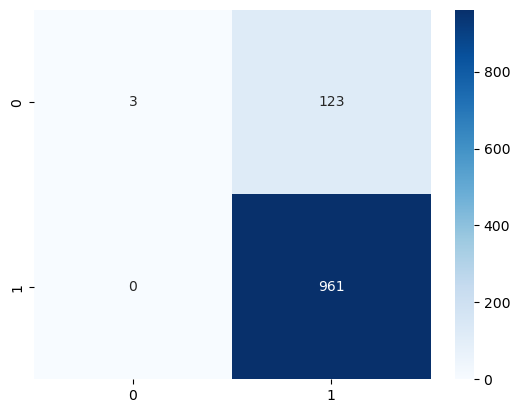

In [5]:
import seaborn as sns

cm = [[  3 ,123],
 [  0 ,961]]
sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')

In [40]:
!pip show torch

Name: torch
Version: 1.13.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /opt/conda/lib/python3.7/site-packages
Requires: typing-extensions
Required-by: accelerate, catalyst, easyocr, fastai, kornia, pytorch-ignite, pytorch-lightning, sentence-transformers, timm, torchaudio, torchmetrics, torchtext, torchvision
